# Overview and Preprocessing

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

import joblib


## Setup

In [ ]:
# Install gdown
!pip install gdown

# Download the ZIP file from the Google Drive link
!gdown --id 1lhwb66fn2iazwWaAqGOFB0ZOD8vm-BDT -O data.zip

# Extract the ZIP file into /content/data and remove the ZIP files
import os
import zipfile

zip_path = 'data.zip'
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

# Extract the main ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Remove the main ZIP file
os.remove(zip_path)
print(f"Removed zip: {zip_path}")

# Remove any nested ZIP files in the destination folder
for root, _, files in os.walk(output_dir):
    for file in files:
        if file.endswith('.zip'):
            zip_file_path = os.path.join(root, file)
            with zipfile.ZipFile(zip_file_path, 'r') as nested_zip_ref:
                nested_zip_ref.extractall(output_dir)
            os.remove(zip_file_path)
            print(f"Removed nested zip: {zip_file_path}")

# Display the extracted files
print("Extracted files in:", output_dir)
print("Contents of the folder:", os.listdir(output_dir))


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lhwb66fn2iazwWaAqGOFB0ZOD8vm-BDT
From (redirected): https://drive.google.com/uc?id=1lhwb66fn2iazwWaAqGOFB0ZOD8vm-BDT&confirm=t&uuid=364e096c-7f47-414b-ab93-abc67d930d7d
To: /content/data.zip
100% 55.2M/55.2M [00:01<00:00, 29.0MB/s]
Removed zip: data.zip
Removed nested zip: data/sample_submission.csv.zip
Removed nested zip: data/test_labels.csv.zip
Removed nested zip: data/train.csv.zip
Removed nested zip: data/test.csv.zip
Extracted files in: data
Contents of the folder: ['sample_submission.csv', 'test.csv', 'test_labels.csv', 'train.csv']


## Load Data

In [ ]:
# Load the training dataset
train = pd.read_csv("data/train.csv")

# Load the test dataset
test = pd.read_csv("data/test.csv")
test_labels = pd.read_csv("data/test_labels.csv")

# Filter out -1 labels from the test dataset
valid_test_indices = (test_labels.drop(columns=["id"]) != -1).any(axis=1)
test = test[valid_test_indices].reset_index(drop=True)
test_labels = test_labels[valid_test_indices].reset_index(drop=True)
test_combined = pd.concat([test, test_labels.drop(columns=["id"])], axis=1)

# Combine train and test_combined
combined = pd.concat([train, test_combined], axis=0).reset_index(drop=True)

# Print the shapes of the datasets
print(f"Shape of the train dataset: {train.shape}")
print(f"Shape of the test_combined dataset: {test_combined.shape}")
print(f"Shape of the combined dataset: {combined.shape}")


Shape of the train dataset: (159571, 8)
Shape of the test_combined dataset: (63978, 8)
Shape of the combined dataset: (223549, 8)


## Dataset Overview

In [ ]:
print("Missing values per column:")
missing_values = combined.isna().sum()
missing_percentage = (missing_values / len(train)) * 100
print(pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage}))

Missing values per column:
               Missing Values  Percentage
id                          0         0.0
comment_text                0         0.0
toxic                       0         0.0
severe_toxic                0         0.0
obscene                     0         0.0
threat                      0         0.0
insult                      0         0.0
identity_hate               0         0.0


In [ ]:
print("Text length distribution:")
train['text_length'] = combined['comment_text'].apply(lambda x: len(str(x)))
print(train['text_length'].describe())


Text length distribution:
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


Label distribution (percentages):
toxic            9.565688
severe_toxic     0.877660
obscene          5.430577
threat           0.308210
insult           5.056610
identity_hate    0.946996
dtype: float64


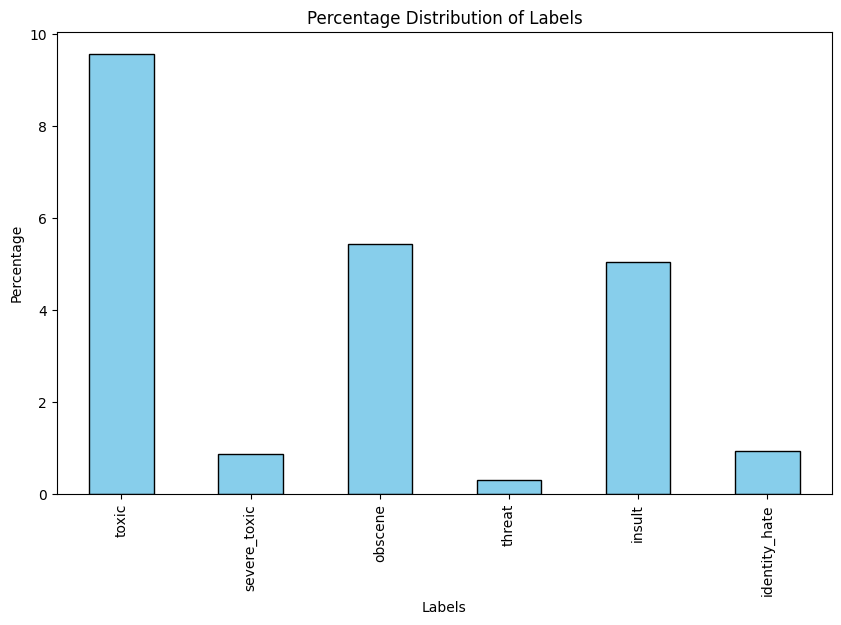

In [ ]:
# Analyze the label distribution in the combined dataset
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

label_distribution = combined[label_columns].sum() / len(combined) * 100
print("Label distribution (percentages):")
print(label_distribution)

# Visualize the distribution with a bar chart
import matplotlib.pyplot as plt

label_distribution.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Percentage Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.show()


Label distribution (percentages relative to toxic documents):
toxic            95.175361
severe_toxic      8.732419
obscene          54.032402
threat            3.066584
insult           50.311554
identity_hate     9.422289
dtype: float64


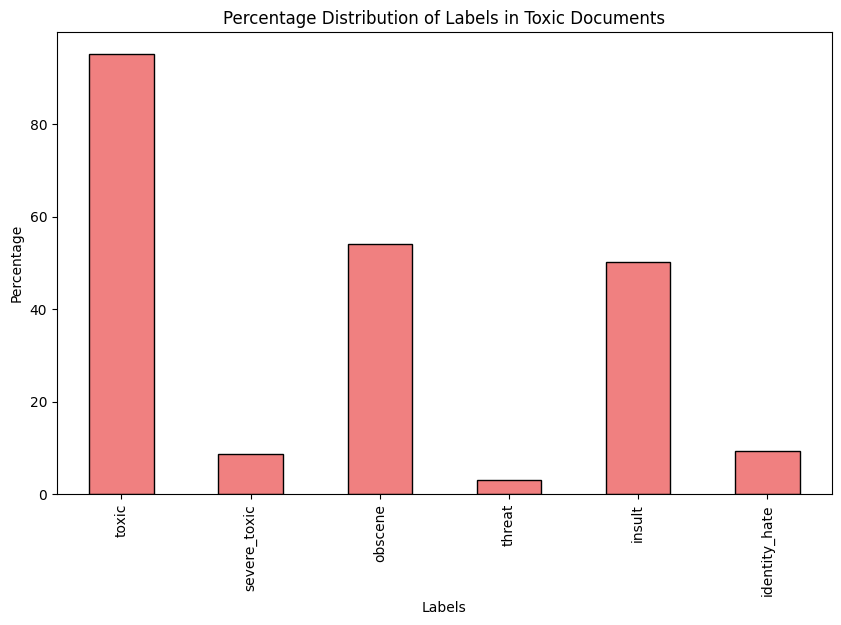

In [ ]:
# Filter documents with at least one active label
toxic_docs = combined[combined[label_columns].sum(axis=1) > 0]

# Calculate the label distribution relative to toxic documents
toxic_label_distribution = toxic_docs[label_columns].sum() / len(toxic_docs) * 100

print("Label distribution (percentages relative to toxic documents):")
print(toxic_label_distribution)

# Visualize the distribution with a bar chart
toxic_label_distribution.plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
plt.title('Percentage Distribution of Labels in Toxic Documents')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.show()


Co-occurrence distribution (counts):
active_labels
0    201081
1      8202
3      6290
2      5010
4      2371
5       550
6        45
Name: count, dtype: int64

Co-occurrence distribution (percentages):
active_labels
0    89.949407
1     3.668994
3     2.813701
2     2.241119
4     1.060618
5     0.246031
6     0.020130
Name: count, dtype: float64


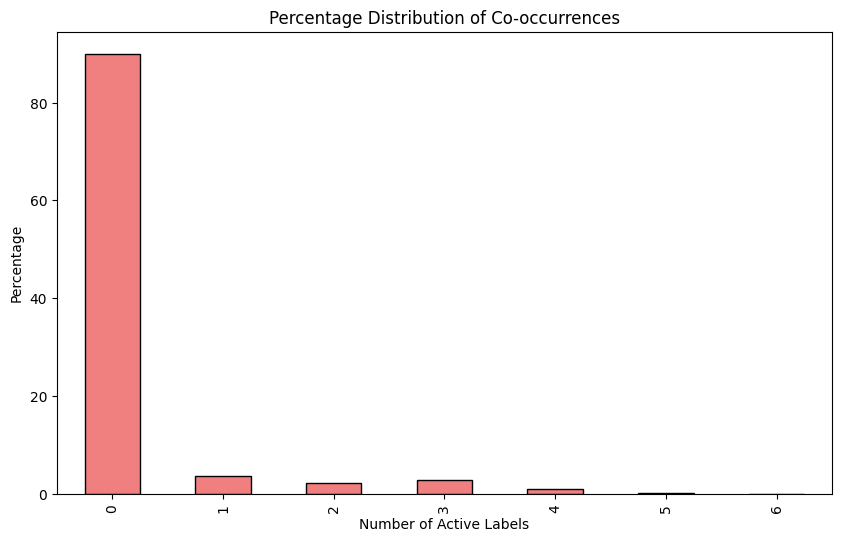

In [ ]:
# Count the number of active labels per row
combined['active_labels'] = combined[label_columns].sum(axis=1)

# Distribution of co-occurrences
cooccurrence_counts = combined['active_labels'].value_counts()
cooccurrence_percentages = (cooccurrence_counts / len(combined)) * 100

print("Co-occurrence distribution (counts):")
print(cooccurrence_counts)

print("\nCo-occurrence distribution (percentages):")
print(cooccurrence_percentages)

# Plot the co-occurrence distribution
cooccurrence_percentages.sort_index().plot(kind='bar', figsize=(10, 6), color='lightcoral', edgecolor='black')
plt.title('Percentage Distribution of Co-occurrences')
plt.xlabel('Number of Active Labels')
plt.ylabel('Percentage')
plt.show()


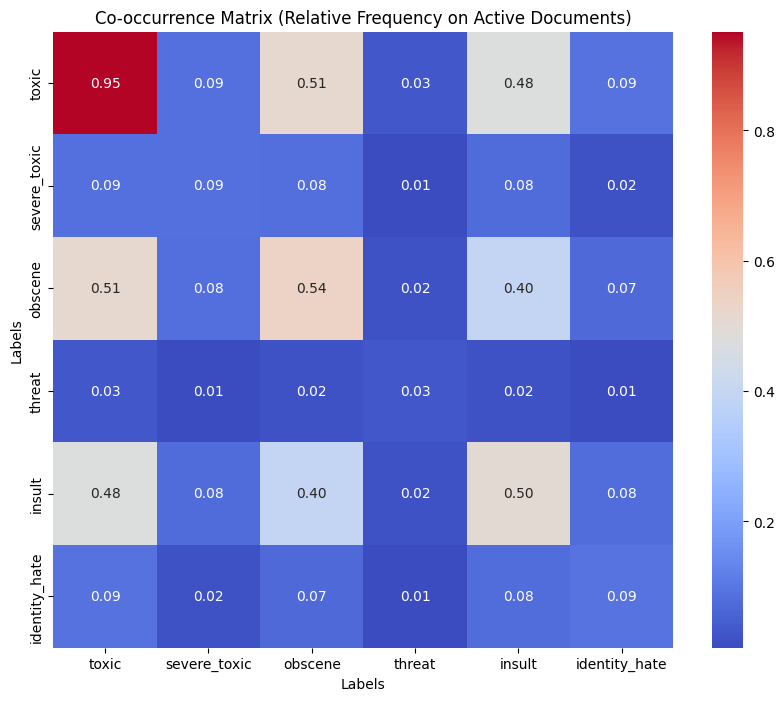

Co-occurrence Matrix (Relative Frequency):
                  toxic  severe_toxic   obscene    threat    insult  \
toxic          0.951754      0.087324  0.514153  0.029108  0.475610   
severe_toxic   0.087324      0.087324  0.083675  0.007032  0.075708   
obscene        0.514153      0.083675  0.540324  0.019539  0.395407   
threat         0.029108      0.007032  0.019539  0.030666  0.019806   
insult         0.475610      0.075708  0.395407  0.019806  0.503116   
identity_hate  0.088793      0.019939  0.069877  0.006454  0.078423   

               identity_hate  
toxic               0.088793  
severe_toxic        0.019939  
obscene             0.069877  
threat              0.006454  
insult              0.078423  
identity_hate       0.094223  


In [ ]:
import numpy as np

# Filter documents with at least one active label
active_docs = combined[combined[label_columns].sum(axis=1) > 0]

# Compute the co-occurrence matrix for active documents
cooccurrence_matrix = np.dot(active_docs[label_columns].T, active_docs[label_columns])

# Compute the relative frequency by dividing by the number of active documents
relative_cooccurrence_matrix = cooccurrence_matrix / len(active_docs)

# Convert to DataFrame for clearer representation
cooccurrence_df = pd.DataFrame(
    relative_cooccurrence_matrix,
    index=label_columns,
    columns=label_columns
)

# Visualize the heatmap of the co-occurrence matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Co-occurrence Matrix (Relative Frequency on Active Documents)")
plt.xlabel("Labels")
plt.ylabel("Labels")
plt.show()

# Display the matrix in tabular format
print("Co-occurrence Matrix (Relative Frequency):")
print(cooccurrence_df)


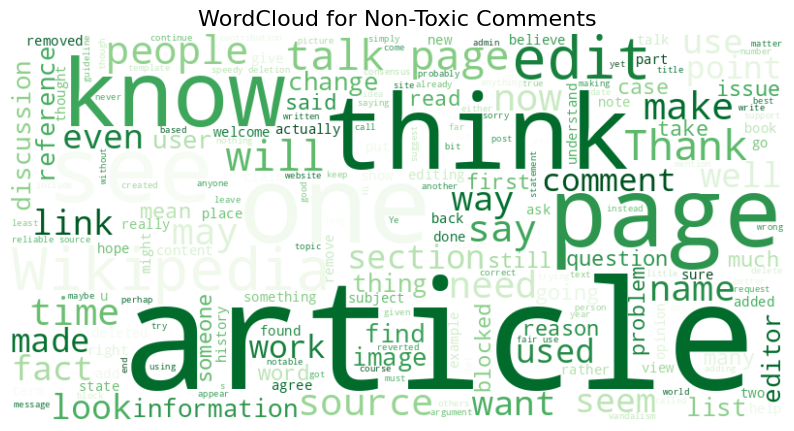

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter non-toxic comments
non_toxic_comments = combined[combined['active_labels'] == 0]['comment_text']

# Combine all non-toxic comments into one large string
non_toxic_text = ' '.join(non_toxic_comments)

# Generate the word cloud for non-toxic comments
non_toxic_wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=200
).generate(non_toxic_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(non_toxic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Non-Toxic Comments', fontsize=16)
plt.show()


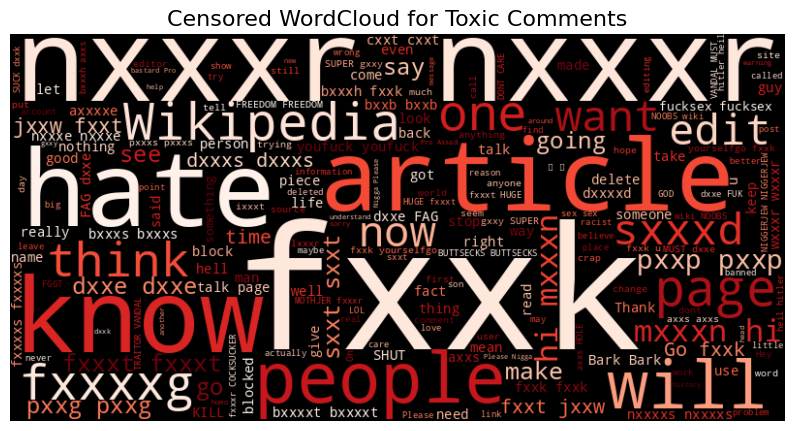

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

blacklist = [
    'fuck', 'fucking', 'fucker', 'nigger', 'niggers',
    'shit', 'bitch', 'cunt', 'asshole', 'dick',
    'faggot', 'faggots', 'moron', 'stupid',
    'fat', 'jew', 'pig', 'balls', 'poop',
    'die', 'loser', 'idiot', 'ass', 'wanker','dickhead', 'penis', 'aids', 'dicks', 'bullshit', 'boob' ,'gay', 'nipple']
# Function to censor words
def censor_words(text, blacklist):
    for word in blacklist:
        # Replace the word with a censored version (e.g., n**ger, f**k)
        censored_word = word[0] + 'x' * (len(word) - len(word)//2) + word[-1]
        text = re.sub(rf'\b{word}\b', censored_word, text, flags=re.IGNORECASE)
    return text

# Filter toxic comments
toxic_comments = combined[combined['active_labels'] > 0]['comment_text']

# Combine all toxic comments into one large string
toxic_text = ' '.join(toxic_comments)

# Censor offensive words
censored_toxic_text = censor_words(toxic_text, blacklist)

# Generate the word cloud for censored toxic comments
censored_toxic_wc = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Reds',
    max_words=200,
    random_state = 42
).generate(censored_toxic_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(censored_toxic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Censored WordCloud for Toxic Comments', fontsize=16)
plt.show()




## Preprocessing and Representation

### Minimal preprocessing + BERT Embedding

#### remove URL, mentions and convert to lowercase

In [ ]:
import re

def minimal_preprocessing(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Convert to lowercase (if using an uncased model)
    text = text.lower()
    return text

# Apply preprocessing
train['minimal_cleaned_comment_text'] = train['comment_text'].apply(minimal_preprocessing)
test_combined['minimal_cleaned_comment_text'] = test_combined['comment_text'].apply(minimal_preprocessing)

# Check the result
print(train[['comment_text', 'minimal_cleaned_comment_text']].head())


                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                        minimal_cleaned_comment_text  
0  explanation\nwhy the edits made under my usern...  
1  d'aww! he matches this background colour i'm s...  
2  hey man, i'm really not trying to edit war. it...  
3  "\nmore\ni can't make any real suggestions on ...  
4  you, sir, are my hero. any chance you remember...  


In [ ]:
import re
import string

import nltk
nltk.download('stopwords')


def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (remove '#' but keep the text after it)
    text = re.sub(r'#', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra characters like newlines and tabs
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

# Apply preprocessing
train['cleaned_comment_text'] = train['comment_text'].apply(preprocess_text)
test_combined['cleaned_comment_text'] = test_combined['comment_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
test_combined = test_combined.fillna('')
train = train.fillna('')

In [ ]:
train.to_csv("train_processed.csv", index=False)
test_combined.to_csv("test_processed.csv", index=False)
